In [1]:
# This code works in Python 3.10.6
import os
import os.path as osp
from typing import Dict, List, Union

import torch
import torch.nn.functional as F
from torch import nn
import dgl
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
from torch_geometric.nn import HANConv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
import random
import seaborn as sns
import torch_geometric.utils.convert
from torch import optim
from torch_geometric.data import HeteroData

from torch_geometric.nn import HeteroConv, Linear, SAGEConv

import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


In [3]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Original IMDB dataset with all node features

In [4]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
print(data)

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)


Dataset with selected node features used for GNN training

In [5]:
data

HeteroData(
  movie={
    x=[4278, 3066],
    y=[4278],
    train_mask=[4278],
    val_mask=[4278],
    test_mask=[4278],
  },
  director={ x=[2081, 3066] },
  actor={ x=[5257, 3066] },
  (movie, to, director)={ edge_index=[2, 4278] },
  (movie, to, actor)={ edge_index=[2, 12828] },
  (director, to, movie)={ edge_index=[2, 4278] },
  (actor, to, movie)={ edge_index=[2, 12828] }
)

In [6]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/han_imdb.py
class HAN(nn.Module):
    def __init__(self, in_channels: Union[int, Dict[str, int]],
                 out_channels: int, hidden_channels=128, heads=8):
        super().__init__()
        self.han_conv = HANConv(in_channels, hidden_channels, heads=heads,
                                dropout=0.6, metadata=data.metadata())
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        out = self.han_conv(x_dict, edge_index_dict)
        out = self.lin(out['movie'])
        return out

def train() -> float:
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['movie'].train_mask
    loss = F.cross_entropy(out[mask], data['movie'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test() -> List[float]:
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['movie'][split]
        acc = (pred[mask] == data['movie'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


In [7]:
import random
def apply_threshold(df):
    return df.applymap(lambda x: random.uniform(-1.0, 0.0) if x == 0.0 else random.uniform(0.1, 1.0))

In [8]:
#Reading from files, the generated node features using diffusion(TabDDPM)
#Download from https://drive.google.com/file/d/1cYWwO4WgfafH3G0bOw69DQsLAFUiJs-5/view in the current folder location and reference the .npy files for movie classes(with feature size 3066), director and actor as below
tabddpm_path = '../../../../../../../graph generator/diffusion models/sampled_features_diffusion/no_dependence/tabddpm/imdb/'

class0  = pd.DataFrame(np.load(tabddpm_path + 'imdb_features_tabddpm/imdb/movie0_tabddpm3066.npy',allow_pickle=True))
class1  = pd.DataFrame(np.load(tabddpm_path + 'imdb_features_tabddpm/imdb/movie1_tabddpm3066.npy',allow_pickle=True))
class2  = pd.DataFrame(np.load(tabddpm_path + 'imdb_features_tabddpm/imdb/movie2_tabddpm3066.npy',allow_pickle=True))

director  = pd.DataFrame(np.load(tabddpm_path + 'imdb_features_tabddpm/imdb/director_tabddpm.npy',allow_pickle=True))
actor  = pd.DataFrame(np.load(tabddpm_path + 'imdb_features_tabddpm/imdb/actor_tabddpm.npy',allow_pickle=True))

df_class0=class0.reset_index(drop=True)
df_class1=class1.reset_index(drop=True)
df_class2=class2.reset_index(drop=True)

In [9]:
def get_node_features(G):
    nodes = []
    director_node_features = []
    movie_node_features = []
    movie_class = []
    actor_node_features = []

    for key, value in G.nodes(data=True):

        nodes.append(key)
        edges = [e for e in G.edges]
        node_id = G.nodes[key]["label"]
        node_type = G.nodes[key]["node_type"]
        if node_type == 0:

            node_id = G.nodes[key]["label"]

            director_node = director.loc[int(node_id), :].values.flatten().tolist()
            director_node_features.append(director_node)
        elif node_type == 2:

            node_class = random.choice([0, 1, 2])

            if node_class == 0:
                
                movie_node = df_class0.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(0)
                movie_node_features.append(movie_node)
                
            elif node_class == 1:
                
                movie_node = df_class1.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(1)
                movie_node_features.append(movie_node)
                
            elif node_class == 2:
                
                movie_node = df_class2.loc[int(node_id), :].values.flatten().tolist()
                movie_class.append(2)
                movie_node_features.append(movie_node)

        elif node_type == 1:
   
            actor_node = actor.loc[int(node_id), :].values.flatten().tolist()
            actor_node_features.append(actor_node)


        movie_node_features_df = pd.DataFrame(movie_node_features)
        movie_node_features_df['class'] = movie_class
        director_node_features_df = pd.DataFrame(director_node_features)
        actor_node_features_df = pd.DataFrame(actor_node_features)

    return nodes, edges, movie_node_features_df, director_node_features_df, actor_node_features_df


In [10]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [11]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [12]:
def get_node_type(node_type):
    if node_type == 1:
        return 'actor'
    elif node_type == 0:
        return 'director'
    elif node_type == 2:
        return 'movie'


In [13]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('actor', 'movie'),
 ('movie', 'actor'),
 ('movie', 'director'),
 ('director', 'movie')]

In [14]:
def create_dataset(nodes,edges,movie_df,director_df,actor_df,node_id,df_graph):
    movie = np.asarray(movie_df.drop(columns=['class']))
    director = np.asarray(director_df)
    actor = np.asarray(actor_df)
    
    x_movie = torch.tensor(movie).to(dtype=torch.float32)
    y_movie = torch.tensor(np.array(movie_df["class"]), dtype=torch.long)
    x_director = torch.tensor(director).to(dtype=torch.float32)
    x_actor = torch.tensor(actor).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    movie_to_director = []
    director_to_movie = []
    movie_to_actor = []
    actor_to_movie = []
    remaining_edges = []

    class_dict = {'Director':0, 'Actor':1, 'Movie':2}

    for i in range(len(edges)):
        if (df_graph.iloc[int(source[i])]['class'] == class_dict['Movie']) and \
        (df_graph.iloc[int(dest[i])]['class'] == class_dict['Director']):
                movie_to_director.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Movie']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Actor']):
                movie_to_actor.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Director']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Movie']):
                director_to_movie.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Actor']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Movie']):
                actor_to_movie.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.iloc[int(source[i])]['class'])
            dest_node_type = get_node_type(df_graph.iloc[int(dest[i])]['class'])
            remaining_edges.append((source_node_type,dest_node_type))
            
            
    all_edges[node_id] = [*movie_to_director,*movie_to_actor,*director_to_movie,*actor_to_movie]
            
    actor = list(df_graph[df_graph['class'] == 1]['nodeId'])
    actor = [int(i) for i in actor]
    actor_nodes_mapping = remap_indices(actor)
    
    director = list(df_graph[df_graph['class'] == 0]['nodeId'])
    director = [int(i) for i in director]
    director_nodes_mapping = remap_indices(director)
    
    movie = list(df_graph[df_graph['class'] == 2]['nodeId'])
    movie = [int(i) for i in movie]
    movie_nodes_mapping = remap_indices(movie)

    node_list = {}
    for d in [movie_nodes_mapping, director_nodes_mapping, actor_nodes_mapping]:
        node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'movie':{'x': x_movie, 'y':y_movie}, 
                              'director':{'x': x_director},'actor':{'x': x_actor}})

    if movie_to_director:
        edge_index_movie_director = preprocess_edges(movie_to_director,node_list)
        small_graph['movie','to','director'].edge_index = edge_index_movie_director
        
    if director_to_movie:
        edge_index_director_movie = preprocess_edges(director_to_movie,node_list)
        small_graph['director','to','movie'].edge_index = edge_index_director_movie
    
    if actor_to_movie:
        edge_index_actor_movie = preprocess_edges(actor_to_movie,node_list)
        small_graph['actor','to','movie'].edge_index = edge_index_actor_movie
        
    if movie_to_actor:
        edge_index_movie_actor = preprocess_edges(movie_to_actor,node_list)
        small_graph['movie','to','actor'].edge_index = edge_index_movie_actor
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)

    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [15]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        small_graph= small_graph.to(device)

        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)

        return softmax.tolist()

In [16]:
import glob
graphs_path = '../../../../../../../graph generator/diffusion models/sampled_graphs_diffusion/'
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'imdb_5to10/*.gexf')]))

Original no of graphs: 1367


In [17]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [18]:
def get_max_pred(softmax_dict,i):
    #Getting the list of predictions for each class
    prob_class0_dict = {}
    prob_class1_dict = {}
    prob_class2_dict = {}
    
    for nodeid in softmax_dict:
        list0= []
        list1= []
        list2= [] 
        if len(softmax_dict[nodeid]) > 0:
            list0= []
            list1= []
            list2= []   
            for prob in softmax_dict[nodeid]:        
                list0.append(prob[0])        
                list1.append(prob[1]) 
                list2.append(prob[2]) 
    
    
         #Taking max probability of all nodes of each class in a graph
        if len(list0) != 0:
            prob_class0_dict[nodeid]=max(list0)
        if len(list1) != 0:
            prob_class1_dict[nodeid]=max(list1)
        if len(list2) != 0:
            prob_class2_dict[nodeid]=max(list2)
    
    max_pred0 = max(prob_class0_dict.values())
    max_pred1 = max(prob_class1_dict.values())
    max_pred2 = max(prob_class2_dict.values())
    
    print('Run'+str(i), max_pred0, max_pred1, max_pred2)
    max_pred_list.append([max_pred0, max_pred1, max_pred2])

    graph_dict_list.append(graph_dict)
    all_edges_list.append(all_edges)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)

    avg_max_pred = (max_pred0+max_pred1+max_pred2)/3
    avg_max_pred_list.append(avg_max_pred)
    
    class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
    class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
    class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)
    
    class_graphid_list.append([class0_graphid,class1_graphid,class2_graphid])

In [19]:
for i in range(0,10):   
    
    model = HAN(in_channels=-1, out_channels=3)
    
    #device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 700):  
        loss = train()
        train_acc, val_acc, test_acc = test()
        if epoch%200==0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
                  f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break
    
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}
    
    #Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
    for filepath in glob.iglob(graphs_path + 'imdb_5to10/*.gexf'):
        
        graph = nx.read_gexf(filepath)
        
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]
        
        nodeId_list = []
        node_type_list = []
    
    
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            node_type_list.append(value['node_type'])
    
        
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
      
    
        nodes,edges,movie_node_features,director_node_features,actor_node_features= get_node_features(graph)
        small_graph_data, removed_edges = create_dataset(nodes,edges,
                                  movie_node_features,director_node_features,
                                  actor_node_features,graph_id,df_graph)
        
        edge_list = all_edges[graph_id]
        graph = nx.Graph(edge_list)
        if not nx.is_empty(graph) and nx.is_connected(graph):
        
            if (small_graph_data['movie'].x.nelement()!=0) and \
                (small_graph_data['actor','to','movie']) and \
                (small_graph_data['movie','to','actor']) and \
                (small_graph_data['movie','to','director']) and \
                (small_graph_data['director','to','movie']):
                
                softmax = evaluate_gnn(small_graph_data)
                softmax_dict[graph_id] = softmax
                nodefeature_dict[graph_id]={'movie':small_graph_data['movie'].x,
                                                 'director':small_graph_data['director'].x,
                                                 'actor':small_graph_data['actor'].x}
                graph_dict[graph_id]=df_graph

    print("No. of graphs evaluated: ",len(softmax_dict))

    get_max_pred(softmax_dict,i)

Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run0 1.0 0.9999995231628418 0.9999988079071045
Epoch: 200, Loss: 0.0605, Train: 1.0000, Val: 0.6125, Test: 0.5676
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run1 1.0 0.9999984502792358 1.0
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run2 1.0 1.0 0.852031409740448
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run3 1.0 1.0 0.9999520778656006
Epoch: 200, Loss: 0.0728, Train: 1.0000, Val: 0.6250, Test: 0.5670
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run4 1.0 0.9999974966049194 1.0
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  188
Run5 1.0 1.0 0.9787240028381348
Stopping training as validation accuracy did not

In [20]:
avg_max_pred_list

[0.9999994436899821,
 0.999999483426412,
 0.9506771365801493,
 0.9999840259552002,
 0.9999991655349731,
 0.9929080009460449,
 0.780119409163793,
 0.9999975760777792,
 0.9998835722605387,
 1.0]

In [21]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.9723567813634872


In [22]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.06571837945724944


In [23]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

9

In [24]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    for g in G.nodes():
              
        if df_graph.loc[g]['class'] == 0:
            classes.append(0)
        if df_graph.loc[g]['class'] == 1:
            classes.append(1)
        if df_graph.loc[g]['class'] == 2:
            classes.append(2)

   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [25]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [26]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [27]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('feature values',fontsize=30)
    plt.ylabel('feature count',fontsize=30)

    plt.show()

In [28]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]

In [29]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]

In [30]:
all_edges = all_edges_list[index]

In [31]:
graph_dict = graph_dict_list[index]

In [32]:
softmax_dict = softmax_dict_list[index]

In [33]:
nodefeature_dict = nodefeature_dict_list[index]

In [34]:
nodefeature_dict = nodefeature_dict_list[index]

Plotting explanation graphs and node features for each class of Movie node

Node colors:

Director - Blue

Actor - Red

Movie - Darkgreen

Number of nodes:  9
graph id:  graph1000
Max pred probability for class 0 is 1.0


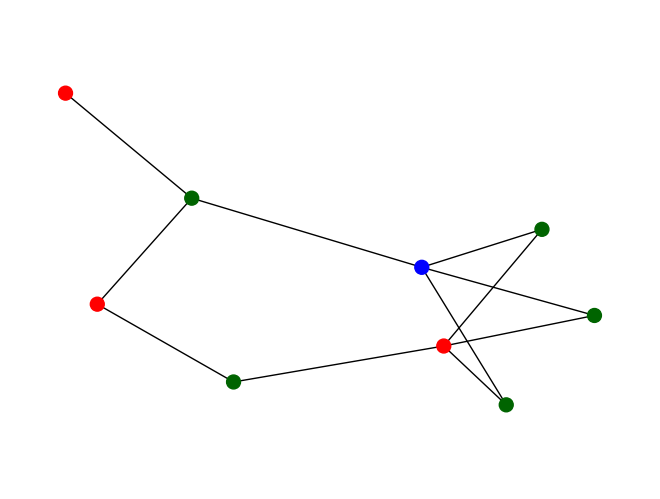

In [35]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [36]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['movie'].cpu().numpy()[ind]
Counter(list0)

Counter({0.0: 2000, 1.0: 926, 2.0: 128, 3.0: 9, 4.0: 2, 5.0: 1})

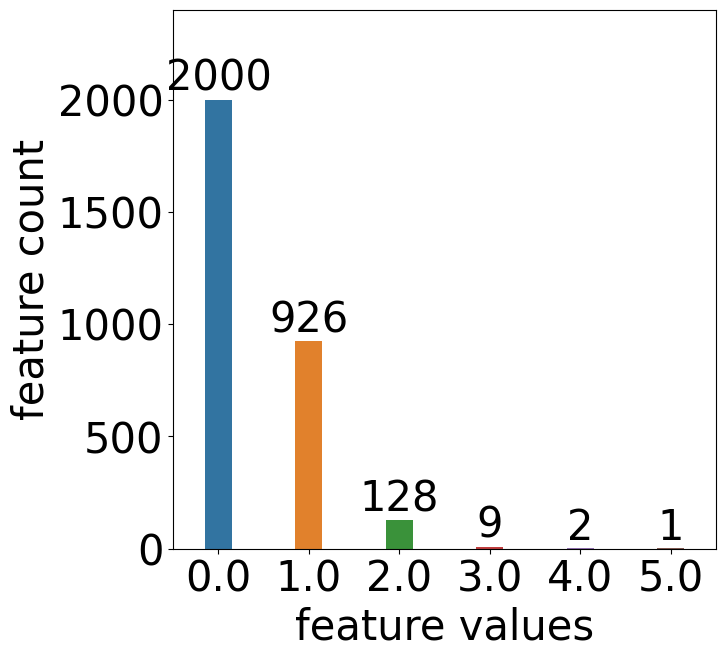

In [37]:
count_plot(list0)

Number of nodes:  10
graph id:  graph1263
Max pred probability for class 1 is 1.0


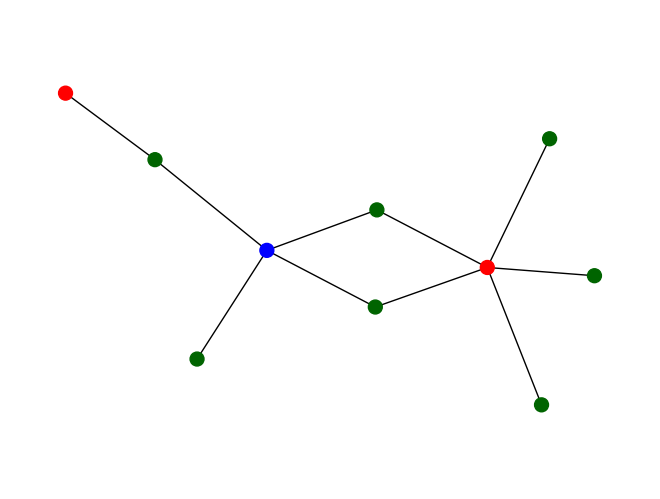

In [38]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

In [39]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['movie'].cpu().numpy()[ind]
Counter(list1)

Counter({0.0: 2209, 1.0: 769, 2.0: 76, 3.0: 11, 4.0: 1})

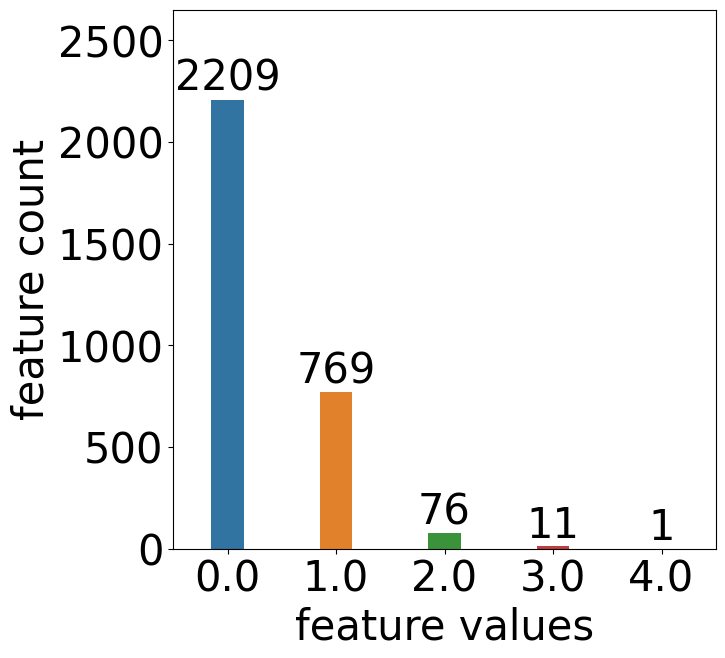

In [40]:
count_plot(list1)

Number of nodes:  10
graph id:  graph1255
Max pred probability for class 2 is 1.0


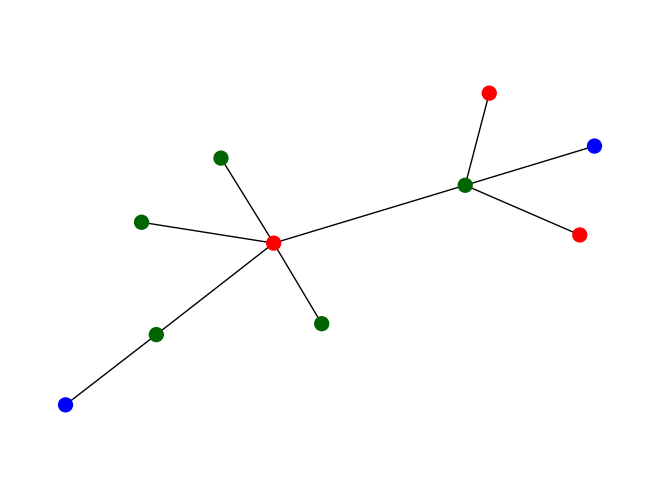

In [41]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

In [42]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['movie'].cpu().numpy()[ind]
Counter(list2)

Counter({0.0: 2048, 1.0: 883, 2.0: 121, 3.0: 10, 4.0: 4})

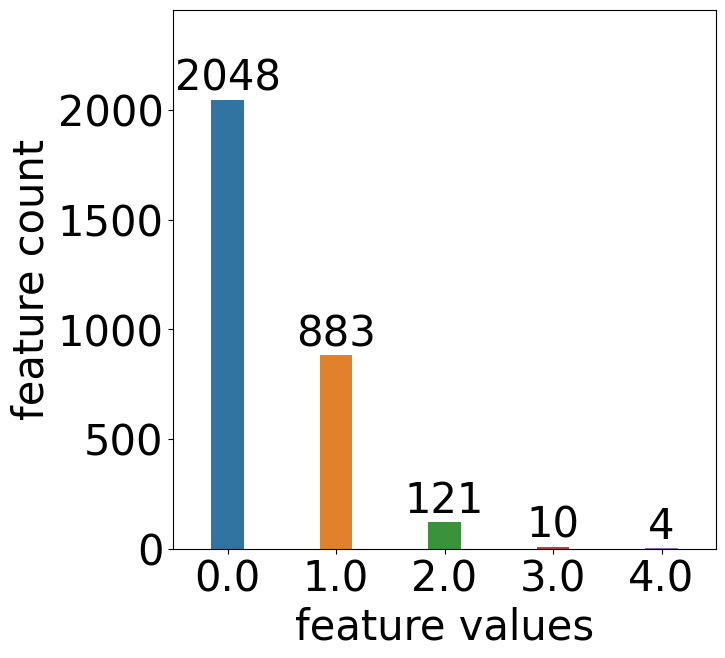

In [43]:
count_plot(list2)

In [44]:
def print_stat_cont_features(df):

    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [45]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show() 

In [46]:
#Actor
actor0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['actor'].cpu().numpy())
print_stat_cont_features(actor0_df)

mean 0.5204005
std dev 0.6208274


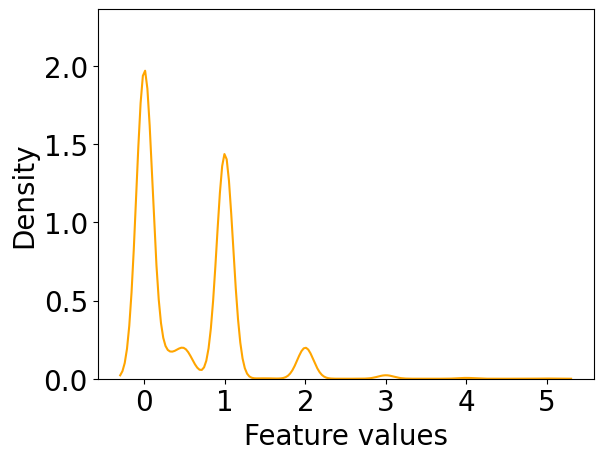

In [47]:
plot_node_feat(actor0_df)

In [48]:
actor1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['actor'].cpu().numpy())
print_stat_cont_features(actor1_df)

mean 0.5199097
std dev 0.6216036


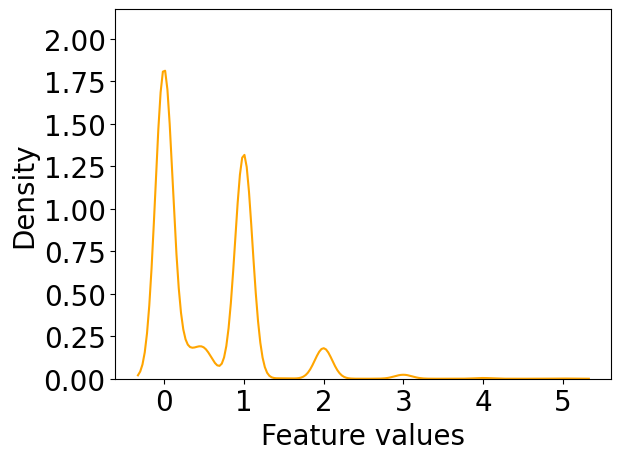

In [49]:
plot_node_feat(actor1_df)

In [50]:
actor2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['actor'].cpu().numpy())
print_stat_cont_features(actor2_df)

mean 0.51364225
std dev 0.6164793


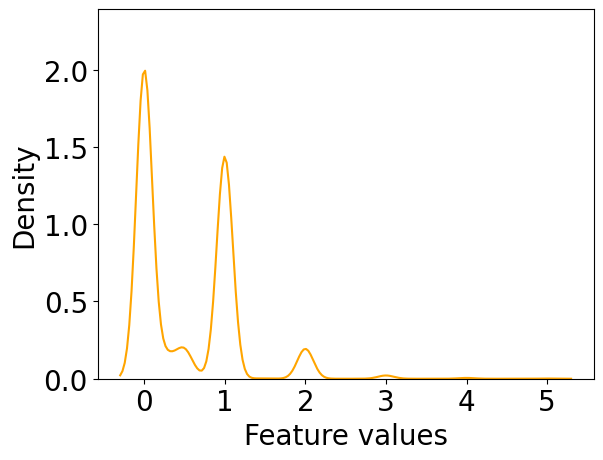

In [51]:
plot_node_feat(actor2_df)

In [52]:
#Director
director0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['director'].cpu().numpy())
print_stat_cont_features(director0_df)

mean 0.4345746
std dev 0.5704978


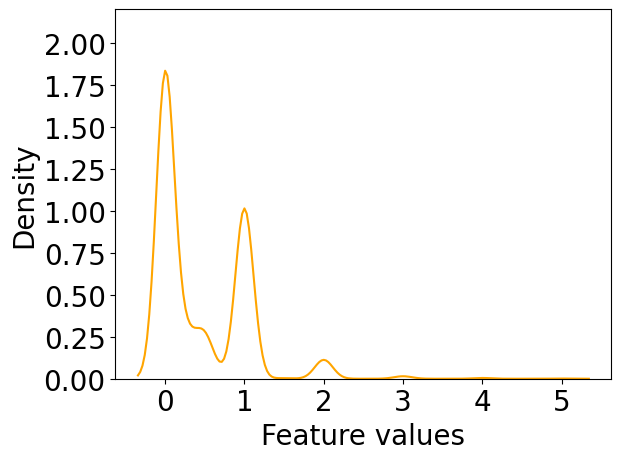

In [53]:
plot_node_feat(director0_df)

In [54]:
director1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['director'].cpu().numpy())
print_stat_cont_features(director1_df)

mean 0.43450513
std dev 0.57856506


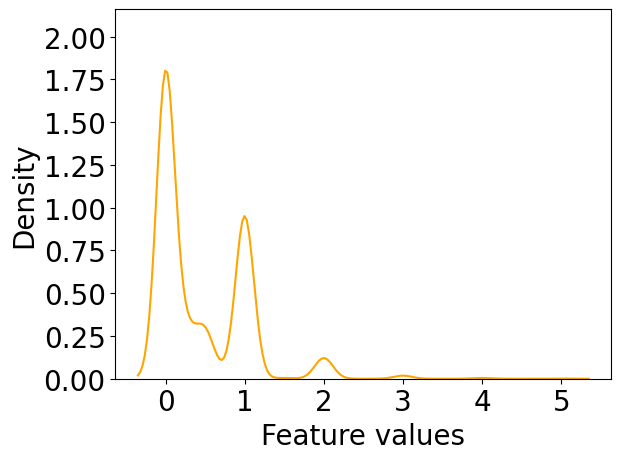

In [55]:
plot_node_feat(director1_df)

In [56]:
director2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['director'].cpu().numpy())
print_stat_cont_features(director2_df)

mean 0.43718922
std dev 0.57502115


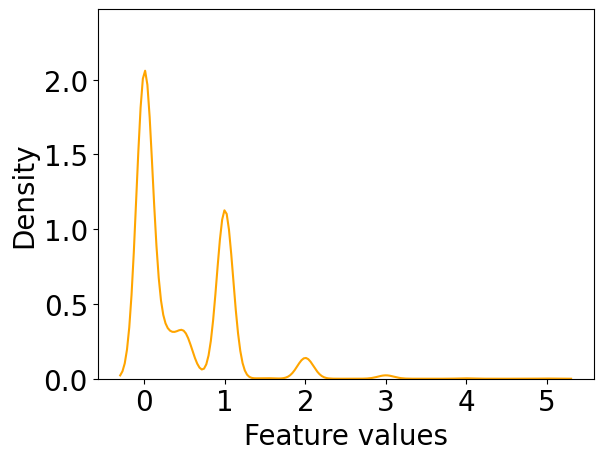

In [57]:
plot_node_feat(director2_df)

In [2]:
motifs_path = '../../../../../common_motifs/imdb_5to10/'
files_motif = os.listdir(motifs_path)

In [3]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

../../../../../common_motifs/imdb_5to10/motif_real_10_0.gexf
../../../../../common_motifs/imdb_5to10/motif_real_10_1.gexf
../../../../../common_motifs/imdb_5to10/motif_real_10_2.gexf
../../../../../common_motifs/imdb_5to10/motif_real_10_3.gexf
../../../../../common_motifs/imdb_5to10/motif_real_10_4.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_0.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_1.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_2.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_3.gexf
../../../../../common_motifs/imdb_5to10/motif_real_5_4.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_0.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_1.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_2.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_3.gexf
../../../../../common_motifs/imdb_5to10/motif_real_6_4.gexf
../../../../../common_motifs/imdb_5to10/motif_real_7_0.gexf
../../../../../common_motifs/imdb_5

In [60]:
def get_faithfulness(graphid_list):
    class_faithfulness = []
    for graphid in graphid_list:
        expln_graph = nx.Graph(all_edges[graphid])
        edges = all_edges_list[i][graphid]
        expln_graph = nx.Graph(edges)

        fid_score_list = []       
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(motifs_path, file_m)

            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            fid_score_list.append(x)

        class_faithfulness.append(np.mean(fid_score_list))

    return np.mean(class_faithfulness)

In [61]:
faithfulness_list = []

for i in range(0,10):
    faithfulness = get_faithfulness(class_graphid_list[i])

    print('Run'+str(i),faithfulness)
    faithfulness_list.append(faithfulness)
print('Mean',np.mean(faithfulness_list))

Run0 0.8777777777777778
Run1 0.9333333333333335
Run2 0.9
Run3 0.8555555555555555
Run4 0.9666666666666667
Run5 0.8888888888888888
Run6 0.9222222222222222
Run7 0.8555555555555555
Run8 0.9111111111111111
Run9 0.9444444444444445
Mean 0.9055555555555556


In [62]:
print('Standard Deviation',np.std(faithfulness_list))

Standard Deviation 0.03522414996477194
